# 11. Attribute Joins  between Geodataframes and  Dataframes

We just mapped the census tracts. But what makes a map powerful is when you map the data associated with the locations.


**INSTRUCTOR NOTES**:
- Datasets used:
    - "../outdata/acs5data_2018_AC.csv"
    - "../notebook_data/census/Tracts/cb_2018_06_tract_500k.zip"
    
- Expected time to complete:
    - Lecture + Questions: 10 minutes
    - Challenges: N/A



<br><br>
## 11.1 Attribute Joins
In order to map the ACS data we need to associate it with the tracts. We have polygon data in the `tracts_gdf_ac` geodataframe but no attributes of interest.

In a separate file we have our ACS 5-year data for 2018 `census_variables_CA.csv` that we just imported and read in as a `pandas` dataframe. We're now going to join the columns from that data to the `tracts_gdf_ac` with a common key. This process is called an `attribute join`, which we covered in an earlier notebook.

We're going to be conducting an inner join here -- think about why we do one type of join over another. You can read more about merging in `geopandas` [here](http://geopandas.org/mergingdata.html#attribute-joins).

<img src="https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2017/03/join-types-merge-names.jpg">



Let's talk about the data and the different join operations. What kind of join do we want to do?

In [1]:
# write any notes here

Let's take another look at the two data objects that we have -- do we see any columns that we can join on between the two?

In [2]:
import math
import numpy as np
import pandas as pd

import json # for working with JSON data
import geojson # ditto for GeoJSON data - an extension of JSON with support for geographic data
import geopandas as gpd

import matplotlib # base python plotting library
%matplotlib inline  
import matplotlib.pyplot as plt # more plotting stuff

In [3]:
# Import the ACS data first
acs5data_df_ac = pd.read_csv('../outdata/acs5data_2018_AC.csv', dtype={'FIPS_11_digit': object})
acs5data_df_ac.head()

,Unnamed: 0,NAME,c_race,c_white,c_black,c_asian,c_latinx,state_fips,county_fips,tract_fips,...,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
0,8323,"Census Tract 4415.01, Alameda County, California",6570,677,111,4740,570,6,1,441501,...,0.925897,0.039593,0.010476,0.019874,0.004160,0.761761,0.113940,0.054812,0.012085,0.003453
1,8324,"Census Tract 4047, Alameda County, California",2079,1515,134,199,175,6,1,404700,...,0.891826,0.028390,0.037690,0.031816,0.010279,0.532093,0.177674,0.158140,0.006512,0.005581
2,8325,"Census Tract 4425, Alameda County, California",7748,1430,375,3379,1904,6,1,442500,...,0.899056,0.073020,0.003802,0.003015,0.021106,0.715315,0.112613,0.064264,0.017718,0.010210
3,8326,"Census Tract 4503, Alameda County, California",5301,2597,96,1077,1315,6,1,450300,...,0.889312,0.025529,0.062107,0.021718,0.001334,0.749202,0.064917,0.094005,0.009933,0.011706
4,8327,"Census Tract 4506.07, Alameda County, California",5971,2832,324,1726,804,6,1,450607,...,0.801863,0.121084,0.043014,0.034039,0.000000,0.698643,0.132730,0.058220,0.021418,0.034389


In [4]:
# ACS 5 year data
acs5data_df_ac.columns

Index(['Unnamed: 0', 'NAME', 'c_race', 'c_white', 'c_black', 'c_asian',
       'c_latinx', 'state_fips', 'county_fips', 'tract_fips', 'med_rent',
       'med_hhinc', 'c_tenants', 'c_owners', 'c_renters', 'c_movers', 'c_stay',
       'c_movelocal', 'c_movecounty', 'c_movestate', 'c_moveabroad',
       'c_commute', 'c_car', 'c_carpool', 'c_transit', 'c_bike', 'c_walk',
       'year', 'FIPS_11_digit', 'p_white', 'p_black', 'p_asian', 'p_latinx',
       'p_owners', 'p_renters', 'p_stay', 'p_movelocal', 'p_movecounty',
       'p_movestate', 'p_moveabroad', 'p_car', 'p_carpool', 'p_transit',
       'p_bike', 'p_walk'],
      dtype='object')

Since its hard to see all of our variables and know what types they are, let's use the `info` method instead.

In [5]:
acs5data_df_ac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     361 non-null    int64  
 1   NAME           361 non-null    object 
 2   c_race         361 non-null    int64  
 3   c_white        361 non-null    int64  
 4   c_black        361 non-null    int64  
 5   c_asian        361 non-null    int64  
 6   c_latinx       361 non-null    int64  
 7   state_fips     361 non-null    int64  
 8   county_fips    361 non-null    int64  
 9   tract_fips     361 non-null    int64  
 10  med_rent       355 non-null    float64
 11  med_hhinc      360 non-null    float64
 12  c_tenants      361 non-null    int64  
 13  c_owners       361 non-null    int64  
 14  c_renters      361 non-null    int64  
 15  c_movers       361 non-null    int64  
 16  c_stay         361 non-null    int64  
 17  c_movelocal    361 non-null    int64  
 18  c_movecoun

Okay, awesome! Now let's go ahead and check our our tracts data.

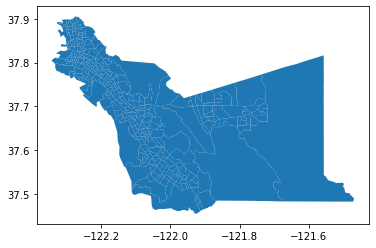

In [6]:
tracts_gdf = gpd.read_file("zip://../notebook_data/census/Tracts/cb_2018_06_tract_500k.zip")
# Limit to alameda county
tracts_gdf_ac = tracts_gdf[tracts_gdf['COUNTYFP']=='001']
tracts_gdf_ac.plot()
plt.show()

In [7]:
# Tracts data
tracts_gdf_ac.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
26,06,001,425101,1400000US06001425101,06001425101,4251.01,CT,590870,2045459,"POLYGON ((-122.31419 37.84231, -122.29923 37.8..."
27,06,001,428600,1400000US06001428600,06001428600,4286,CT,898967,1080420,"POLYGON ((-122.27993 37.76818, -122.27849 37.7..."


So it seems like `GEOID` in our tracts data and `FIPS_11_digit` are going to be the keys in our join. 

<img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="20" align=left >  Let's check those variables-- do you see any differences?

In [8]:
tracts_gdf_ac['GEOID'].head()

26    06001425101
27    06001428600
28    06001432600
29    06001433200
30    06001433900
Name: GEOID, dtype: object

In [9]:
acs5data_df_ac['FIPS_11_digit'].head()

0    06001441501
1    06001404700
2    06001442500
3    06001450300
4    06001450607
Name: FIPS_11_digit, dtype: object

A `join` requires data to be of the same type and same values. Are we good to go?

In [10]:
# Write your thoughts here

Use the `geopandas` `merge` command to join the two dataframes by matching the values in the `GEOID` and `FIPS_11_digit` columns. Then take a look at the output since it should contain our ACS data for Alameda County.

In [11]:
# Uncomment to view documentation 
#acs5data_df_ac.merge?

Let's do a `left` join to keep all of the census tracts in Alameda County and only the ACS data for those tracts.

In [12]:
# Left join keeps all tracts and the acs data for those tracts
tracts_acs_gdf_ac = tracts_gdf_ac.merge(acs5data_df_ac, left_on='GEOID',right_on="FIPS_11_digit", how='left')
tracts_acs_gdf_ac.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME_x,LSAD,ALAND,AWATER,geometry,...,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
0,06,001,425101,1400000US06001425101,06001425101,4251.01,CT,590870,2045459,"POLYGON ((-122.31419 37.84231, -122.29923 37.8...",...,0.865239,0.036524,0.035894,0.037154,0.025189,0.550998,0.107539,0.169623,0.015521,0.062084
1,06,001,428600,1400000US06001428600,06001428600,4286,CT,898967,1080420,"POLYGON ((-122.27993 37.76818, -122.27849 37.7...",...,0.767469,0.067846,0.110467,0.036532,0.017686,0.550140,0.019048,0.270588,0.034734,0.035294


Let's see all the variables we have in our dataset now.

In [13]:
list(tracts_acs_gdf_ac.columns)

['STATEFP',
 'COUNTYFP',
 'TRACTCE',
 'AFFGEOID',
 'GEOID',
 'NAME_x',
 'LSAD',
 'ALAND',
 'AWATER',
 'geometry',
 'Unnamed: 0',
 'NAME_y',
 'c_race',
 'c_white',
 'c_black',
 'c_asian',
 'c_latinx',
 'state_fips',
 'county_fips',
 'tract_fips',
 'med_rent',
 'med_hhinc',
 'c_tenants',
 'c_owners',
 'c_renters',
 'c_movers',
 'c_stay',
 'c_movelocal',
 'c_movecounty',
 'c_movestate',
 'c_moveabroad',
 'c_commute',
 'c_car',
 'c_carpool',
 'c_transit',
 'c_bike',
 'c_walk',
 'year',
 'FIPS_11_digit',
 'p_white',
 'p_black',
 'p_asian',
 'p_latinx',
 'p_owners',
 'p_renters',
 'p_stay',
 'p_movelocal',
 'p_movecounty',
 'p_movestate',
 'p_moveabroad',
 'p_car',
 'p_carpool',
 'p_transit',
 'p_bike',
 'p_walk']

How many rows and columns should we have? Think about this before you run the next lines of code.

In [14]:
print("Rows and columns in the Alameda County Census tract gdf:", tracts_gdf_ac.shape)
print("Rows and columns in the Alameda County Census tract gdf joined to the ACS data:", tracts_acs_gdf_ac.shape)

Rows and columns in the Alameda County Census tract gdf: (360, 10)
Rows and columns in the Alameda County Census tract gdf joined to the ACS data: (360, 55)


<div style="display:inline-block;vertical-align:top;">
    <img src="http://www.pngall.com/wp-content/uploads/2016/03/Light-Bulb-Free-PNG-Image.png" width="30" align=left > 
</div>  
<div style="display:inline-block;">

#### Question
</div>

1. What would happen if we did a inner join instead of a left join? A right join? 
2. What is data type of output of the merge?

In [15]:
# Put your thoughts here

In [16]:
# Check the data type of the join output
type(tracts_acs_gdf_ac)

geopandas.geodataframe.GeoDataFrame

## 11.2 Join Order Matters!

Above, we lefted joined the ACS5 dataframe to the tracts geodataframe. The ouput was a geodataframe of all census tracts and the ACS data for those tracts.

We can do do a similar operation by joining the tracts geodataframe to the ACS dataframe.  However, if we change the order of inputs we get a different type of output!

Let's check that out

In [17]:
tracts_acs_df_ac = acs5data_df_ac.merge(tracts_gdf_ac, right_on='GEOID', left_on="FIPS_11_digit", how='right')

In [18]:
type(tracts_acs_df_ac)

pandas.core.frame.DataFrame

In [19]:
print(tracts_acs_gdf_ac.shape)
print(tracts_acs_df_ac.shape)

(360, 55)
(360, 55)


In [20]:
tracts_acs_df_ac.columns

Index(['Unnamed: 0', 'NAME_x', 'c_race', 'c_white', 'c_black', 'c_asian',
       'c_latinx', 'state_fips', 'county_fips', 'tract_fips', 'med_rent',
       'med_hhinc', 'c_tenants', 'c_owners', 'c_renters', 'c_movers', 'c_stay',
       'c_movelocal', 'c_movecounty', 'c_movestate', 'c_moveabroad',
       'c_commute', 'c_car', 'c_carpool', 'c_transit', 'c_bike', 'c_walk',
       'year', 'FIPS_11_digit', 'p_white', 'p_black', 'p_asian', 'p_latinx',
       'p_owners', 'p_renters', 'p_stay', 'p_movelocal', 'p_movecounty',
       'p_movestate', 'p_moveabroad', 'p_car', 'p_carpool', 'p_transit',
       'p_bike', 'p_walk', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID',
       'GEOID', 'NAME_y', 'LSAD', 'ALAND', 'AWATER', 'geometry'],
      dtype='object')

The number of rows and columns in the output is the same for both joins but the output type is different - even though the pandas dataframe contains a geometry column.

So be careful when joining Geopandas geodataframes and Pandas dataframes. Always check your outputs to make sure they are what you expect.

Before we move on let's make sure to save our work

In [25]:
tracts_acs_gdf_ac.to_file("../outdata/tracts_acs_gdf_ac.json", driver="GeoJSON") 

<div style="display:inline-block;vertical-align:top;">
    <img src="../../assets/images/IMG_9738.JPG" align=center width=600 > 
</div>  
<div style="display:inline-block;">

    
---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="../../assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>
